In [ ]:
from math import sqrt
from numpy import concatenate

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
plt.rcParams["figure.figsize"] = [22,22]

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:

data = read_csv('drive/MyDrive/data2/data.csv')
data.date = pd.to_datetime(data.date)
data.set_index(['date'],inplace=True)
values = data.values
data

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117


In [ ]:
values.shape

(19735, 28)

In [ ]:

def sup(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = concat(cols, axis=1)
	agg.columns = names

	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [ ]:
frame = sup(scaled, 1, 1)
frame

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var19(t),var20(t),var21(t),var22(t),var23(t),var24(t),var25(t),var26(t),var27(t),var28(t)
1,0.046729,0.428571,0.327349,0.566187,0.225345,0.684038,0.215188,0.746066,0.351351,0.764262,...,0.226500,0.678532,0.369239,0.100000,0.894737,0.476190,0.894872,0.533937,0.372083,0.372083
2,0.046729,0.428571,0.327349,0.541326,0.225345,0.682140,0.215188,0.748871,0.351351,0.782437,...,0.219563,0.676049,0.365488,0.102327,0.894737,0.452381,0.835897,0.529412,0.572848,0.572848
3,0.037383,0.428571,0.327349,0.530502,0.225345,0.679445,0.215188,0.755569,0.344745,0.778062,...,0.219563,0.671909,0.361736,0.104652,0.894737,0.428571,0.776923,0.524887,0.908261,0.908261
4,0.037383,0.571429,0.327349,0.524080,0.225345,0.678414,0.215188,0.758685,0.341441,0.770949,...,0.219563,0.671909,0.357985,0.106977,0.894737,0.404762,0.717949,0.520362,0.201611,0.201611
5,0.046729,0.571429,0.327349,0.531419,0.225345,0.676727,0.215188,0.758685,0.341441,0.762697,...,0.219563,0.667356,0.354234,0.109303,0.894737,0.380952,0.658974,0.515837,0.898441,0.898441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,0.074766,0.000000,0.923266,0.545913,0.718052,0.620602,0.841088,0.575946,0.864865,0.766823,...,0.864724,0.729443,0.891747,0.602327,0.416667,0.238095,0.348718,0.901961,0.861981,0.861981
19731,0.084112,0.000000,0.926786,0.537657,0.711655,0.606309,0.830841,0.579374,0.864865,0.765258,...,0.864724,0.729443,0.887460,0.602327,0.421053,0.250000,0.361538,0.900452,0.985726,0.985726
19732,0.074766,0.000000,0.919747,0.536006,0.701769,0.607836,0.825302,0.582178,0.864865,0.765258,...,0.864724,0.729443,0.883173,0.602327,0.425439,0.261905,0.374359,0.898944,0.583979,0.583979
19733,0.242991,0.142857,0.919747,0.538666,0.692651,0.627198,0.818378,0.603988,0.864865,0.771233,...,0.864724,0.730581,0.878885,0.602327,0.429825,0.273810,0.387179,0.897436,0.126371,0.126371


In [ ]:
column_nos=range(29,56)
frame.drop(frame.columns[column_nos], axis=1, inplace=True)
print(frame.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.046729   0.428571   0.327349   0.566187   0.225345   0.684038   
2   0.046729   0.428571   0.327349   0.541326   0.225345   0.682140   
3   0.037383   0.428571   0.327349   0.530502   0.225345   0.679445   
4   0.037383   0.571429   0.327349   0.524080   0.225345   0.678414   
5   0.046729   0.571429   0.327349   0.531419   0.225345   0.676727   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var20(t-1)  var21(t-1)  \
1   0.215188   0.746066   0.351351    0.764262  ...    0.677290    0.372990   
2   0.215188   0.748871   0.351351    0.782437  ...    0.678532    0.369239   
3   0.215188   0.755569   0.344745    0.778062  ...    0.676049    0.365488   
4   0.215188   0.758685   0.341441    0.770949  ...    0.671909    0.361736   
5   0.215188   0.758685   0.341441    0.762697  ...    0.671909    0.357985   

   var22(t-1)  var23(t-1)  var24(t-1)  var25(t-1)  var26(t-1)  var27(t-1)  \
1    0.097675    0.89

In [ ]:
values = frame.values
n_train_hours = 10000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [ ]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


In [ ]:

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
train_X.shape

(10000, 1, 28) (10000,) (9734, 1, 28) (9734,)


(10000, 1, 28)

In [ ]:
train_X.shape[2]

28

In [ ]:

model= Sequential()
model.add(LSTM(50,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(train_X, train_y, epochs=20, batch_size=72,validation_data=(test_X,test_y),verbose=2, shuffle=False)


Epoch 1/20
139/139 - 3s - loss: 0.0548 - val_loss: 0.0505 - 3s/epoch - 23ms/step
Epoch 2/20
139/139 - 1s - loss: 0.0396 - val_loss: 0.0311 - 697ms/epoch - 5ms/step
Epoch 3/20
139/139 - 1s - loss: 0.0380 - val_loss: 0.0287 - 885ms/epoch - 6ms/step
Epoch 4/20
139/139 - 1s - loss: 0.0435 - val_loss: 0.0361 - 605ms/epoch - 4ms/step
Epoch 5/20
139/139 - 1s - loss: 0.0313 - val_loss: 0.0306 - 699ms/epoch - 5ms/step
Epoch 6/20
139/139 - 1s - loss: 0.0315 - val_loss: 0.0271 - 603ms/epoch - 4ms/step
Epoch 7/20
139/139 - 1s - loss: 0.0321 - val_loss: 0.0272 - 616ms/epoch - 4ms/step
Epoch 8/20
139/139 - 1s - loss: 0.0346 - val_loss: 0.0389 - 581ms/epoch - 4ms/step
Epoch 9/20
139/139 - 1s - loss: 0.0329 - val_loss: 0.0364 - 602ms/epoch - 4ms/step
Epoch 10/20
139/139 - 1s - loss: 0.0300 - val_loss: 0.0329 - 710ms/epoch - 5ms/step
Epoch 11/20
139/139 - 1s - loss: 0.0294 - val_loss: 0.0310 - 922ms/epoch - 7ms/step
Epoch 12/20
139/139 - 1s - loss: 0.0294 - val_loss: 0.0316 - 886ms/epoch - 6ms/step
Epo

In [ ]:
model.save('drive/MyDrive/test7_model.model')

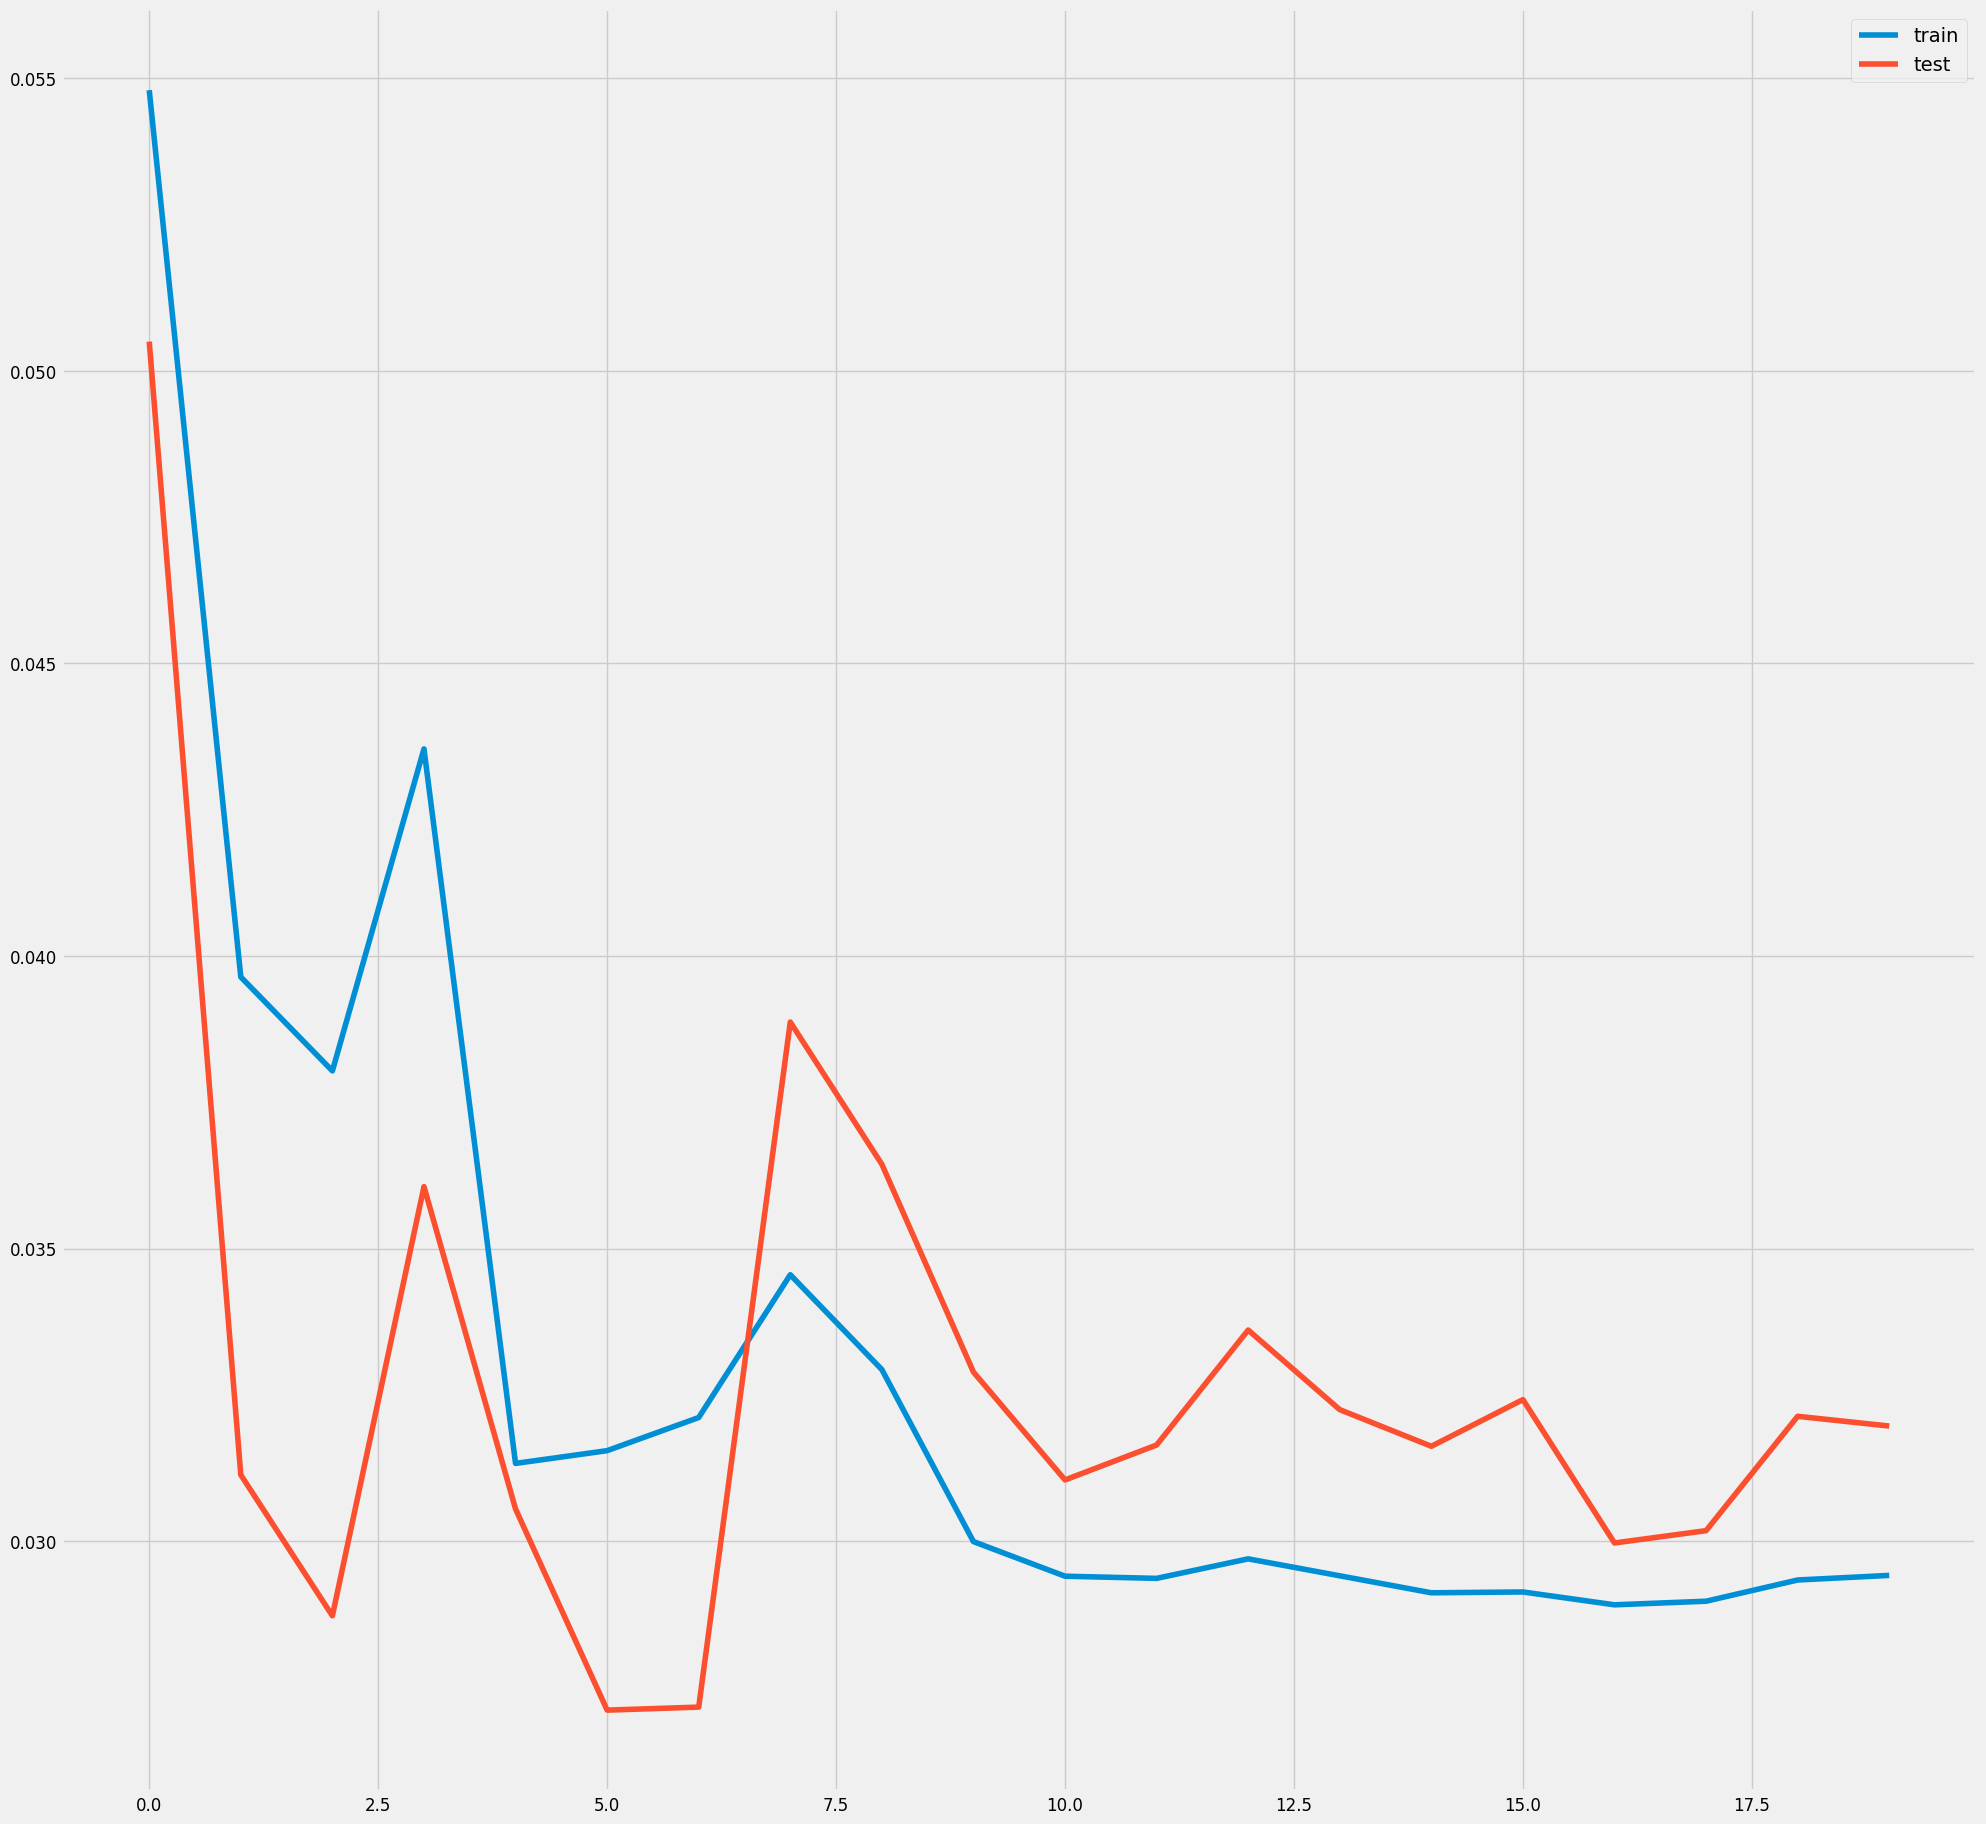

In [ ]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

305/305 [==============================] - 1s 2ms/step


In [ ]:

inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [ ]:

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [ ]:
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

[]

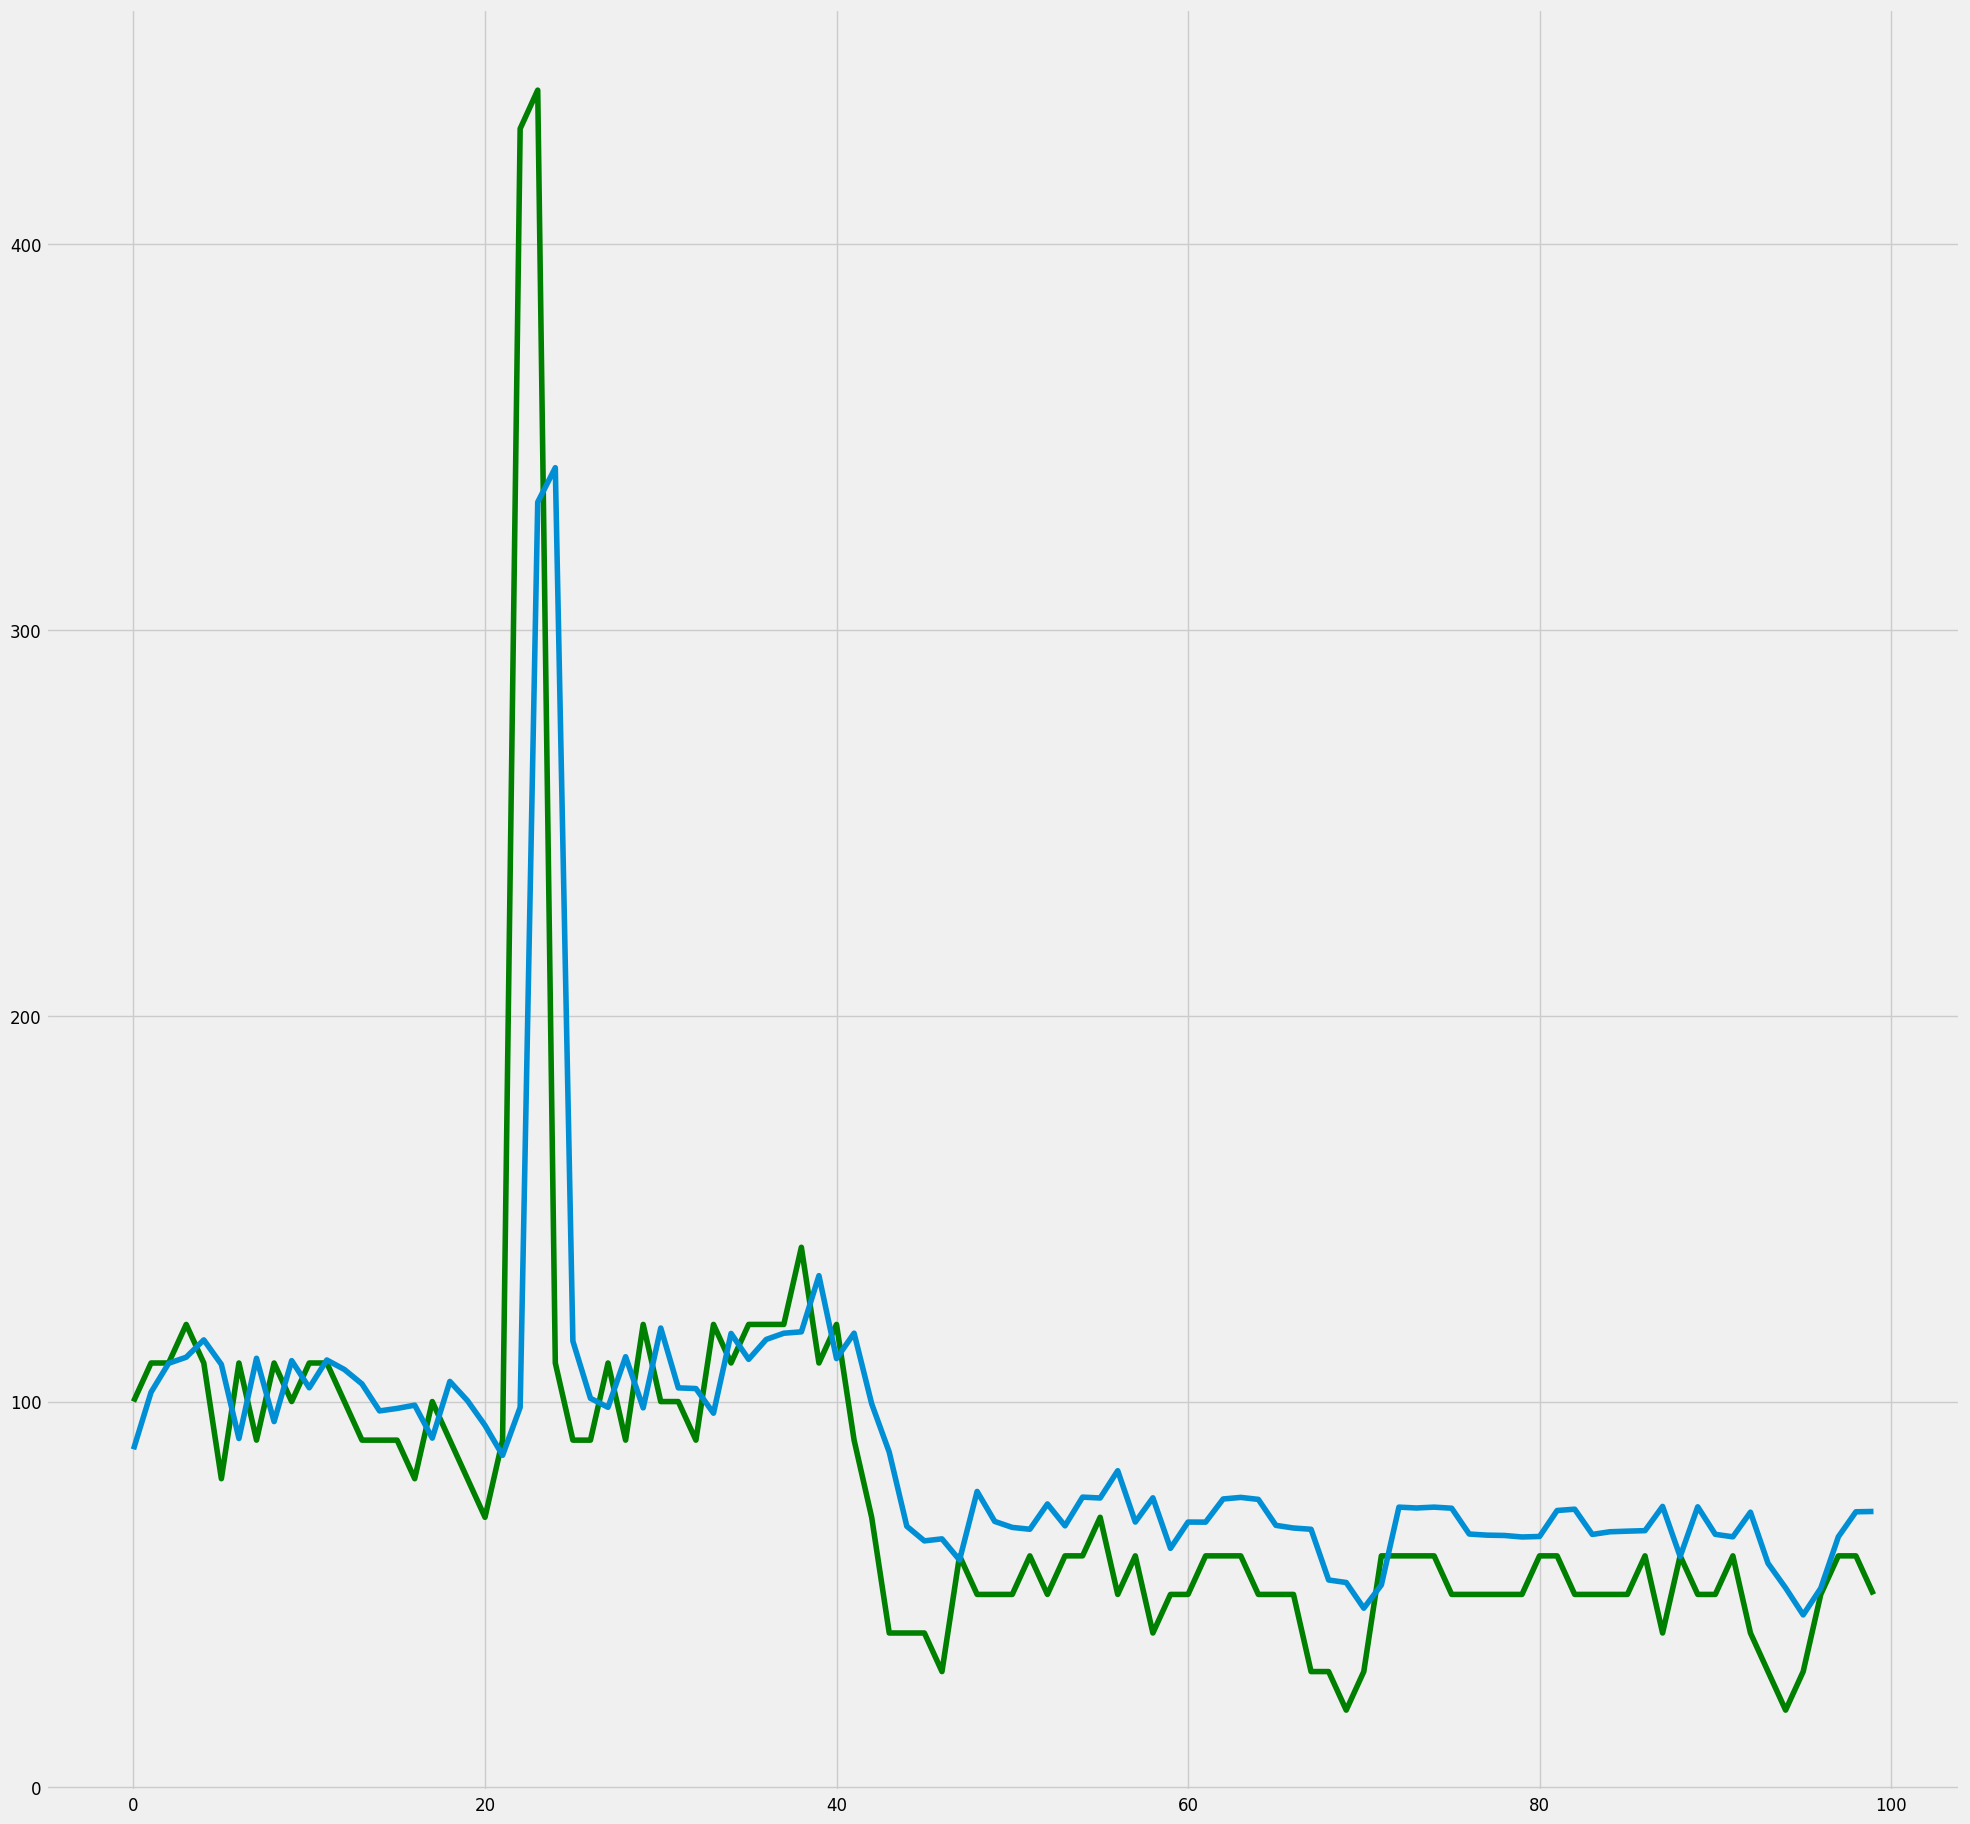

In [ ]:
%matplotlib inline
plt.plot(inv_y[1500:1600], color='green', label='Expected')
plt.plot(inv_yhat[1500:1600], label='Predicted')
plt.plot()

In [ ]:
df = pd.DataFrame({'Actual': inv_y,'Predicted':inv_yhat})

In [ ]:
df

,Actual,Predicted
0,70.0,61.230614
1,50.0,73.750420
2,50.0,60.255238
3,60.0,61.061867
4,50.0,67.744583
...,...,...
9729,100.0,110.780327
9730,90.0,117.673622
9731,270.0,111.660866
9732,420.0,228.217758


#FIN


In [ ]:
import scipy
import sklearn
import keras
import keras.preprocessing 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
train=data[:826]
test=data[826:]

scaled_train=scaler.fit_transform(train)
scaled_test=scaler.transform(test)

ValueError: ignored